Import  all required libraries 

In [0]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
import requests # library to handle requests
import json # library to handle JSON files

In [0]:
import bs4 as bs
import urllib.request

In [4]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
pip install geocoder

     |████████████████████████████████| 102kB 3.3MB/s 


In [0]:
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans

In [0]:
import folium # map rendering library

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [10]:
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')

Matplotlib version:  3.1.3
Libraries imported.


In [0]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [0]:
# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

In [0]:
table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [0]:
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df.loc[df['Neighbourhood']=='Not assigned', ['Neighbourhood']] = 'Queen\'s Park'


In [15]:
link = "http://cocl.us/Geospatial_data"
df1=pd.read_csv(link)
df1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
df1.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df1.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [0]:
df2=pd.merge(df,df1,on='PostalCode')

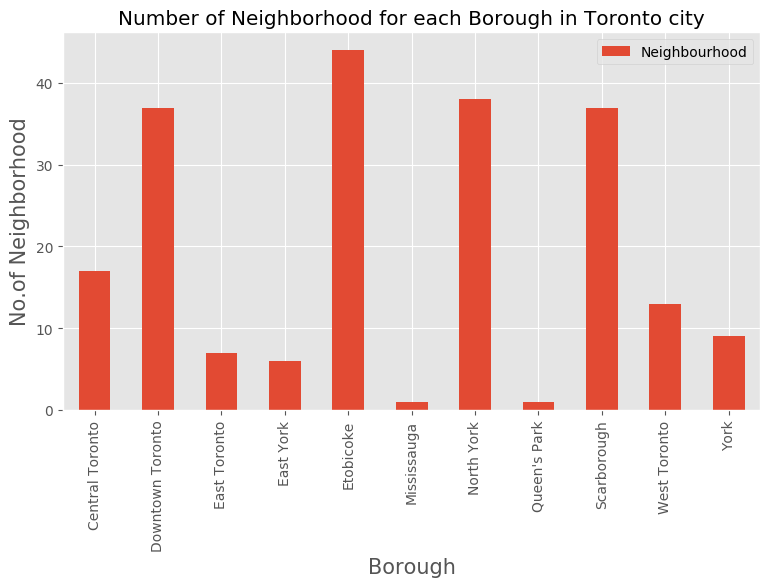

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto city')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df2.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [0]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [0]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0M4UMUBEZKXLVLQMO05QINUFIQODTVSVVPRZK041ITFVYXEL' # your Foursquare ID
    CLIENT_SECRET = 'DS0P12N2GLDF0RTSEFO1V0O41TBNECMVBKSOMD4BDYW3SXCO' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking

In [0]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0M4UMUBEZKXLVLQMO05QINUFIQODTVSVVPRZK041ITFVYXEL' # your Foursquare ID
    CLIENT_SECRET = 'DS0P12N2GLDF0RTSEFO1V0O41TBNECMVBKSOMD4BDYW3SXCO' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [0]:
import os

In [26]:
# prepare neighborhood list that contains indian resturants
column_names=['PostalCode','Borough', 'Neighbourhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in df2.values.tolist():
    PostalCode,Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df2),')','Indian Resturants in '+Neighbourhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'PostalCode':PostalCode,
                                                'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 210 ) Indian Resturants in Parkwoods, North York:0
( 2 / 210 ) Indian Resturants in Victoria Village, North York:0
( 3 / 210 ) Indian Resturants in Harbourfront, Downtown Toronto:2
( 4 / 210 ) Indian Resturants in Lawrence Heights, North York:0
( 5 / 210 ) Indian Resturants in Lawrence Manor, North York:0
( 6 / 210 ) Indian Resturants in Queen's Park, Downtown Toronto:1
( 7 / 210 ) Indian Resturants in Queen's Park, Queen's Park:0
( 8 / 210 ) Indian Resturants in Rouge, Scarborough:0
( 9 / 210 ) Indian Resturants in Malvern, Scarborough:0
( 10 / 210 ) Indian Resturants in Don Mills North, North York:0
( 11 / 210 ) Indian Resturants in Woodbine Gardens, East York:0
( 12 / 210 ) Indian Resturants in Parkview Hill, East York:0
( 13 / 210 ) Indian Resturants in Ryerson, Downtown Toronto:0
( 14 / 210 ) Indian Resturants in Garden District, Downtown Toronto:0
( 15 / 210 ) Indian Resturants in Glencairn, North York:0
( 16 / 210 ) Indian Resturants in Cloverdale, Etobicoke:0
( 17 / 210 )

In [27]:
indian_rest_ny.head()

,PostalCode,Borough,Neighbourhood,ID,Name
0,M5A,Downtown Toronto,Harbourfront,4af9a379f964a520c91222e3,Bombay Palace
1,M5A,Downtown Toronto,Harbourfront,52af6dc5498e33995b0bbf03,Sultan Of Samosas
2,M7A,Downtown Toronto,Queen's Park,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine
3,M4E,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
4,M1G,Scarborough,Woburn,4c632edeedd320a19ad5ae29,Bombay Palace


In [28]:
indian_rest_ny.shape

(74, 5)

74  Indian resturant in Toronto city

Display No.of resturant Borough wise

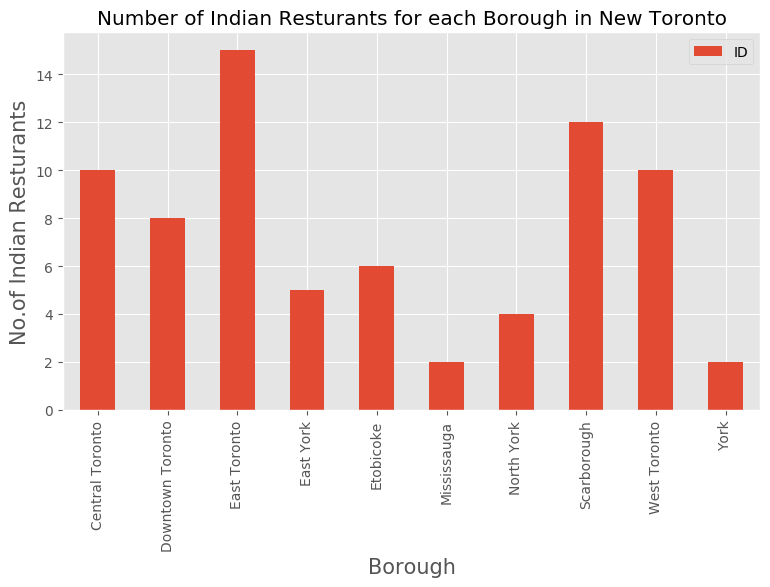

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Borough East Toronto has  maximum number of Indain restuarant

Display Number of Indian  restuarant neighbourhood wise

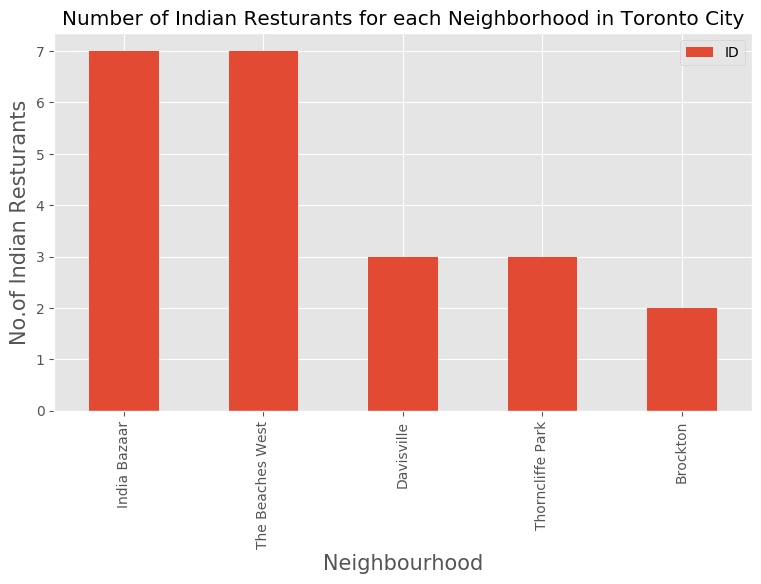

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in Toronto City')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [31]:
indian_rest_ny[indian_rest_ny['Neighbourhood']=='India Bazaar']

,PostalCode,Borough,Neighbourhood,ID,Name
27,M4L,East Toronto,India Bazaar,4ae0c7a8f964a520638221e3,Udupi Palace
28,M4L,East Toronto,India Bazaar,4afc9816f964a520312422e3,Motimahal
29,M4L,East Toronto,India Bazaar,4bac30a2f964a52018ea3ae3,Bombay Chowpatty
30,M4L,East Toronto,India Bazaar,4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
31,M4L,East Toronto,India Bazaar,4ad9052cf964a520301721e3,Regency Restaurant
32,M4L,East Toronto,India Bazaar,4d8d278a1d06b1f712942a3b,Gautama
33,M4L,East Toronto,India Bazaar,4ae4c793f964a5201b9e21e3,The Famous Indian Restaurant


Here we do further analysis 

In [32]:
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    PostalCode,Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'PostalCode':PostalCode,
                                                'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4af9a379f964a520c91222e3  Bombay Palace     14     7.4    13
( 1 / 74 ) processed
                         ID               Name  Likes  Rating  Tips
0  52af6dc5498e33995b0bbf03  Sultan Of Samosas      9     7.0     4
( 2 / 74 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4bedf8b5e24d20a17b567214  Kothur Indian Cuisine     16     8.3    19
( 3 / 74 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      6     7.1     3
( 4 / 74 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c632edeedd320a19ad5ae29
( 5 / 74 ) processed
                         ID                   Name  Likes  Rating  Tips
0  504bcf32e4b0ef19b0e2ecf8  Mt Everest Restaurant      8     6.3     6
( 6 / 74 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4a

KeyError: ignored

In [33]:
indian_rest_stats_ny.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips,PostalCode
0,Downtown Toronto,South of Bloor,4af9a379f964a520c91222e3,Bombay Palace,14,7.4,13,M5A
1,Downtown Toronto,South of Bloor,52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,7.0,4,M5A
2,Downtown Toronto,South of Bloor,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.3,19,M7A
3,East Toronto,South of Bloor,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,7.1,3,M4E
4,Scarborough,South of Bloor,0,0,0,0.0,0,M1G


In [34]:
indian_rest_stats_ny.shape

(50, 8)

In [35]:
indian_rest_ny.shape

(74, 5)

So we got data for all resturants Now lets save this data to a csv sheet

In [0]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [0]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [38]:
indian_rest_stats_ny_csv.shape

(50, 8)

In [81]:
indian_rest_stats_ny_csv.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips,PostalCode
0,Downtown Toronto,South of Bloor,4af9a379f964a520c91222e3,Bombay Palace,14,7.4,13,M5A
1,Downtown Toronto,South of Bloor,52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,7.0,4,M5A
2,Downtown Toronto,South of Bloor,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.3,19,M7A
3,East Toronto,South of Bloor,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,7.1,3,M4E
4,Scarborough,South of Bloor,0,0,0,0.0,0,M1G


In [82]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
Borough          50 non-null object
Neighbourhood    50 non-null object
ID               50 non-null object
Name             50 non-null object
Likes            50 non-null float64
Rating           50 non-null float64
Tips             50 non-null float64
PostalCode       50 non-null object
dtypes: float64(3), object(5)
memory usage: 3.2+ KB


In [0]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [0]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [85]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood              South of Bloor
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                                 142
Rating                                8.9
Tips                                   75
PostalCode                            M6G
Name: 6, dtype: object

In [86]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood              South of Bloor
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                                 142
Rating                                8.9
Tips                                   75
PostalCode                            M6G
Name: 6, dtype: object

In [87]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood              South of Bloor
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                                 142
Rating                                8.9
Tips                                   75
PostalCode                            M6G
Name: 6, dtype: object

In [0]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
ny_neighborhood_stats.columns=['Neighbourhood','Average Rating']

In [89]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
0,South of Bloor,6.594


In [0]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [91]:

ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
6,West Toronto,8.025
1,Downtown Toronto,7.960
0,Central Toronto,6.900
4,North York,6.600
5,Scarborough,6.350


average rating of Indian Resturants for each Borough

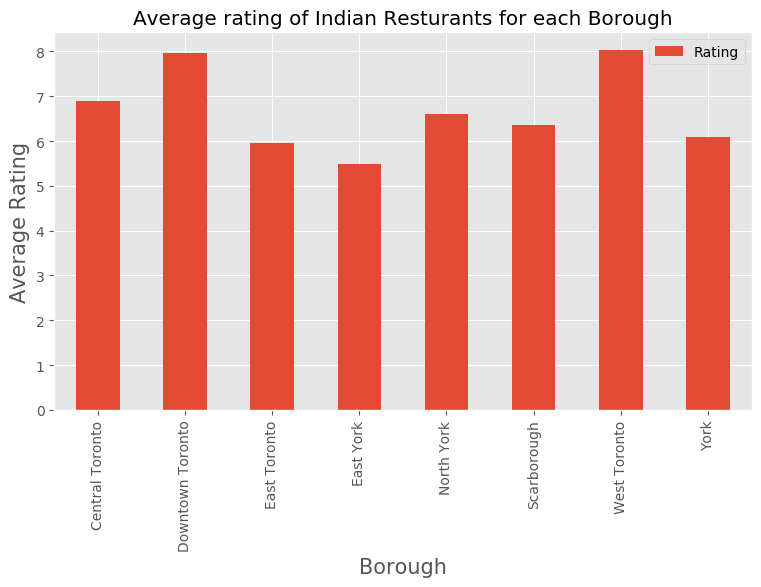

In [92]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [0]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=6.0]

In [94]:
ny_neighborhood_stats

,Neighbourhood,Average Rating
0,South of Bloor,6.594


In [0]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df2, on='Neighbourhood')


Now we will show this data on a map

In [0]:
ny_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

In [0]:
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [0]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighbourhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [99]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [100]:
ny_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
ny_geo = r'/content/toronto.geojson'

folium.Choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
).add_to(ny_map)


In [101]:
type(ny_map)

folium.folium.Map

In [0]:
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')